## Install prerequisite libraries

In [ ]:
# !pip install pymatgen
# !pip install ase
# !pip install mp_api

# Run examples

In [1]:
from pymatgen.analysis.local_env import MinimumDistanceNN
def get_act_site_index(struct, ads_idx):
    '''
    Inputs: pymatgen structure, adsorbate index
    Output: active site index
    '''
    cutoff_dist = 4.
    mnn = MinimumDistanceNN(cutoff=cutoff_dist, get_all_sites=True)
    nn_list = mnn.get_nn_info(struct,ads_idx)
    act_site_idx = 0
    act_site_dist = 10
    for nn in nn_list:
        if nn['site'].specie != Element('H'):
            if nn['weight'] < act_site_dist:
                act_site_dist = nn['weight']
                act_site_idx = nn['site_index']
    return act_site_idx

In [ ]:
from pymatgen.core.structure import Structure
import pickle
import numpy as np
import pandas
import copy
from classical_descriptors import *
from moments_descriptors import *
from mp_api.client import MPRester
define_global_variables_moments()
define_global_variables_classical(4.5)

# Load the data file
with open('./example_data.pkl','rb') as pf:
    ds_full = pickle.load(pf)   # Dataset is loaded here

# Initialize list for storing the calculated descriptors
new_list = list()
for d in ds_full:
    # Obtain the CIF for the bulk structure from Materials Project
    # Comment out this code if you have CIF structure already in the dataset:
    # Your API key here
    mp_api_key = '7CIuGl1xbKasdaqBiimUYc8EaqvEbmJe'
    with MPRester(mp_api_key) as mpr:
        docs = mpr.materials.search(
            material_ids=[mat_id], fields=['initial_structures'])
    d['cif_struct'] = docs[0].initial_structures[0]
    # bulk_V = get_bulk_V(docs[0].initial_structures[0])
    # new_dict['CN_bar_sd']  = mu2_value/(bulk_V)

    # Make pymatgen Structure object for further calculations
    atom_list_init = d['init_struct']['atoms']['atoms']
    atom_list_fin = d['final_struct']['atoms']
    # Lists of species and coordinates are initialized here
    specie_list = list()
    coords_list_init = list()
    coords_list_fin = list()
    # Slab lattice is stored here
    lattice = d['init_struct']['atoms']['cell']
    for at_init, at_fin in zip(atom_list_init, atom_list_fin):
        specie_list.append(Element(at_init['symbol']))
        coords_list_init.append(at_init['position'])
        coords_list_fin.append(at_fin['position'])
    # Obtain the pymatgen structure
    py_struct_init = Structure(lattice, specie_list, coords_list_init, coords_are_cartesian=True)
    py_struct_fin = Structure(lattice, specie_list, coords_list_fin, coords_are_cartesian=True)

    # active_site_index = get_site_index_from_coords(py_struct_init, get_act_site_coords(py_struct_init, d['adsorbate']))
    # For GAS dataset, 0 is the adsorbate index
    active_site_index = get_act_site_index(py_struct_init,0)
    active_site_coords = atom_list_init[active_site_index]['position']
    active_site_coords_fin = atom_list_fin[active_site_index]['position']
    
    new_dict = dict()
    new_dict = copy.deepcopy(d)
    new_dict['psi'] = get_psi(py_struct_init, active_site_coords)
    mu2_value = get_mu2_sum(py_struct_fin, active_site_coords_fin)

    cif_struct = d['cif_struct']
    bulk_V = get_bulk_V(d['cif_struct'])
    new_dict['CN_bar_sd']  = mu2_value/(bulk_V)
    
    new_dict['CN_max'] = get_CN_max(cif_struct)
    new_dict['CN'] = get_CN(py_struct_init, active_site_coords)
    new_dict['CN_bar'] = get_CN_bar(py_struct_init, active_site_coords, new_dict['CN_max'])
    new_list.append(new_dict)
df = pandas.DataFrame(new_list)

## Plot energy values based on columns

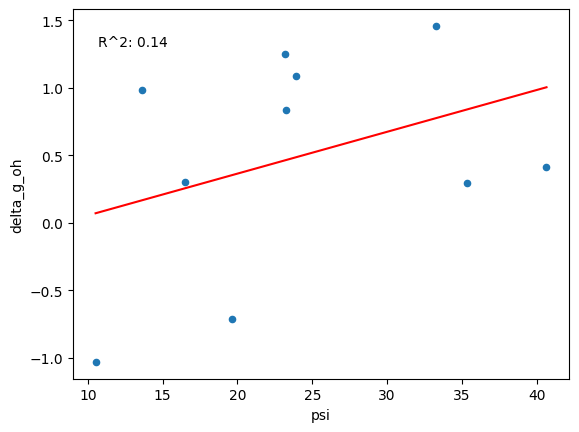

In [25]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

# Column name
descriptor = 'psi'      # Change based on requirement
energy_column = 'delta_g_oh'
# Use a scatter plot
ax = df.plot.scatter(x=descriptor,y=energy_column)

# Get the best-fit line
coeffs = np.polyfit(df[descriptor],df[energy_column],1)
p = np.poly1d(coeffs)
x_line = np.linspace(df[descriptor].min(), df[descriptor].max(), 100)
ax.plot(x_line, p(x_line), color='red')
# Get R^2 values
slope, intercept, r_value, p_value, std_err = stats.linregress(df[descriptor], df[energy_column])
r_squared = r_value**2
ax.annotate(f"R^2: {r_squared:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')

# Add labels to the plot
plt.xlabel(descriptor)
plt.ylabel(energy_column)
plt.show()